In [133]:

# import packages for time series analysis and modeling
import pandas as pd  # data structures for time series analysis
import numpy as np
import datetime  # date manipulation
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA  # time series modeling
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import itertools
from pandas import Grouper
import seaborn as sns
!pip install Prophet
from fbprophet import Prophet
import datetime
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

ModuleNotFoundError: No module named 'fbprophet'

In [56]:
zillow_data = pd.read_csv('lab2data.csv')

In [57]:
num_rows= zillow_data.shape[0]
print(num_rows)
zillow_data.head()

29540


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/97,...,4/30/22,5/31/22,6/30/22,7/31/22,8/31/22,9/30/22,10/31/22,11/30/22,12/31/22,1/31/23
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,109765.7560,...,276356.4793,280421.3471,284426.8053,285576.2499,284496.1795,283508.6110,281634.2213,279244.2138,276586.3233,274329.1947
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,187591.3288,...,496717.0977,505713.5475,512611.5679,512997.9737,509467.0445,505789.4802,502349.2366,498837.3238,493993.8457,490917.0441
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,89089.5541,...,193390.2651,195669.9347,198258.3402,200131.6424,200299.1346,200593.2903,201102.0964,201352.8630,200816.1555,202637.9331
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,192722.1934,...,869495.9642,883379.8542,904820.6168,907381.2980,909499.1300,904429.7167,901782.4890,906069.3390,897735.4125,895789.8059
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,178634.1284,...,785826.9629,797860.5510,812697.8791,812948.0655,812824.1253,810061.8120,807608.9519,808485.1758,801567.0108,802243.0220


In [58]:
print(zillow_data.dtypes)

RegionID        int64
SizeRank        int64
RegionName      int64
RegionType     object
StateName      object
               ...   
9/30/22       float64
10/31/22      float64
11/30/22      float64
12/31/22      float64
1/31/23       float64
Length: 322, dtype: object


In [59]:
num_missing_per_column = zillow_data.isnull().sum().sum()

print(num_missing_per_column)

1905448


In [60]:
zillow_data[['RegionName', 'State', 'City', 'CountyName']] = zillow_data[['RegionName', 'State', 'City', 'CountyName']].astype(str)


In [61]:
zillow_data.dropna(inplace=True)
print( zillow_data.isnull().sum().sum())
num_rows_clean = zillow_data.shape[0]
print(num_rows_clean)

0
12187


In [62]:
hot_springs = zillow_data.loc[(zillow_data['Metro'] == 'Hot Springs, AR')]
little_rock = zillow_data.loc[(zillow_data['Metro'] == 'Little Rock-North Little Rock-Conway, AR') ]
fayetteville = zillow_data.loc[(zillow_data['Metro'] == 'Fayetteville-Springdale-Rogers, AR') ]
searcy = zillow_data.loc[(zillow_data['Metro'] == 'Searcy, AR')]

In [63]:
hot_springs  = hot_springs[hot_springs.columns[9:325]]
little_rock = little_rock[little_rock.columns[9:325]]
fayetteville = fayetteville[fayetteville.columns[9:325]]
searcy = searcy[searcy.columns[9:325]]

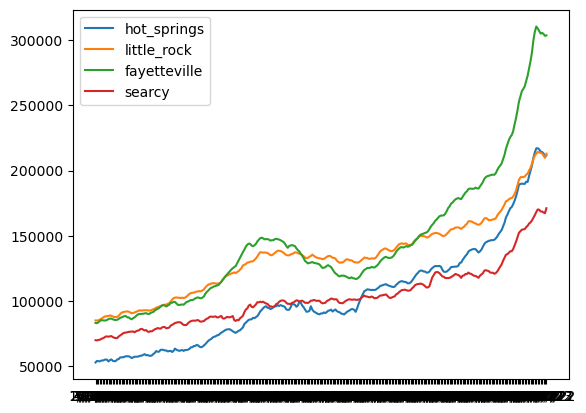

In [64]:
fig, ax = plt.subplots()
ax.plot(hot_springs.mean(), linestyle='solid')
ax.plot(little_rock.mean(), linestyle='solid')
ax.plot(fayetteville.mean(), linestyle='solid')
ax.plot(searcy.mean(), linestyle='solid')



plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

plt.show()

In [68]:
#create new DF with only required metro areas to do more visualizations    
Arkansas = zillow_data.query('Metro in ["Hot Springs, AR", "Little Rock-North Little Rock-Conway, AR", "Fayetteville-Springdale-Rogers, AR", "Searcy, AR"]')
Arkansas = Arkansas.drop(['RegionType','StateName'], axis=1)


In [238]:
Arkansas_new  = Arkansas[Arkansas.columns[5:321]]
Arkansas_new.head()

,Metro,CountyName,1/31/97,2/28/97,3/31/97,4/30/97,5/31/97,6/30/97,7/31/97,8/31/97,...,4/30/22,5/31/22,6/30/22,7/31/22,8/31/22,9/30/22,10/31/22,11/30/22,12/31/22,1/31/23
685,"Fayetteville-Springdale-Rogers, AR",Washington County,93958.28784,93946.55318,94502.50319,95410.64907,95919.31544,96696.27632,97504.73735,98189.84241,...,275229.7307,280735.4973,284937.1752,285605.4705,285509.9322,284892.3362,285474.2683,284474.7897,282058.7071,283720.7559
1116,"Fayetteville-Springdale-Rogers, AR",Washington County,91367.72957,91204.75576,92065.00240,92744.36510,93926.03839,94835.27690,95585.76051,96173.33442,...,366179.6338,375057.0226,379635.5169,378389.3080,376600.2555,376526.7671,376506.7905,374468.8638,370119.6933,369314.5751
1522,"Fayetteville-Springdale-Rogers, AR",Benton County,78743.10013,78366.77418,78697.33516,83615.95924,84951.73995,84789.91768,84493.98561,84667.17118,...,305500.2916,312766.2965,317983.0656,318187.9009,317031.1667,316455.7172,317875.1180,317059.9418,315176.4964,319259.8977
1526,"Fayetteville-Springdale-Rogers, AR",Benton County,129849.18170,130037.40170,130948.07340,132090.45480,133187.26630,131509.45640,132368.32900,132016.17300,...,449417.8835,462472.4992,468459.3082,467714.2322,465346.0122,463527.3752,466311.5827,465887.8269,463206.2421,462423.6067
1742,"Little Rock-North Little Rock-Conway, AR",Pulaski County,64640.12314,64281.59423,64236.93350,64052.60786,64934.47601,65519.52425,66487.35698,66903.89334,...,142939.7621,144739.2325,145882.0605,147859.0782,147966.4883,147708.4220,147378.4475,146113.0363,146255.3099,150763.9500


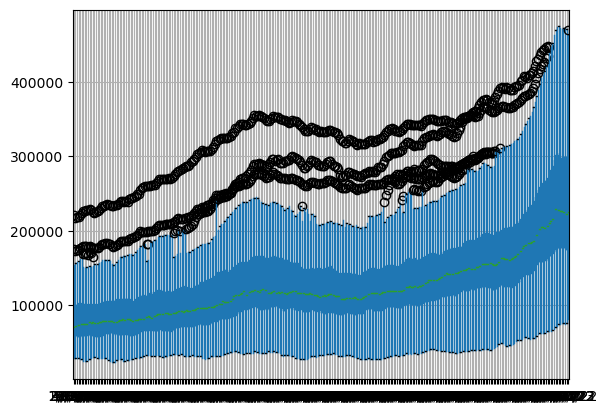

In [239]:
Arkansas_new.boxplot()
plt.show()


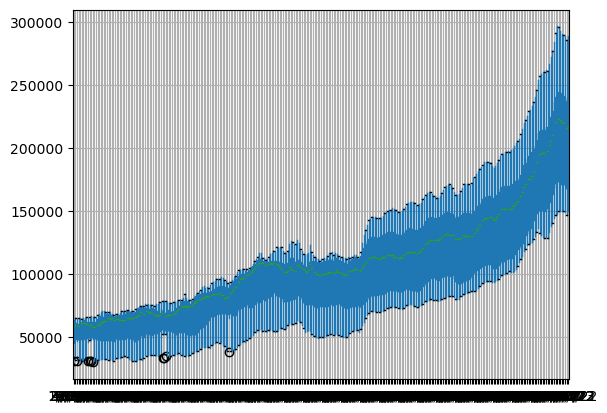

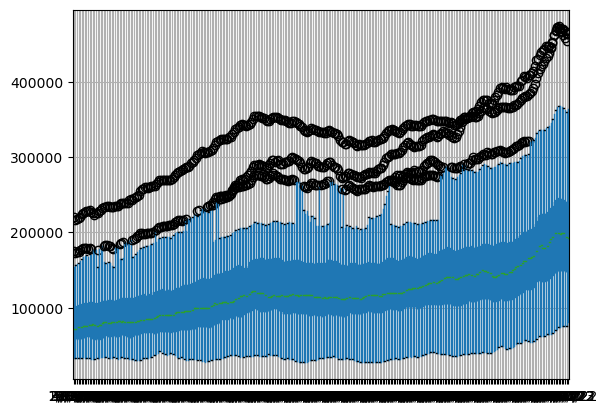

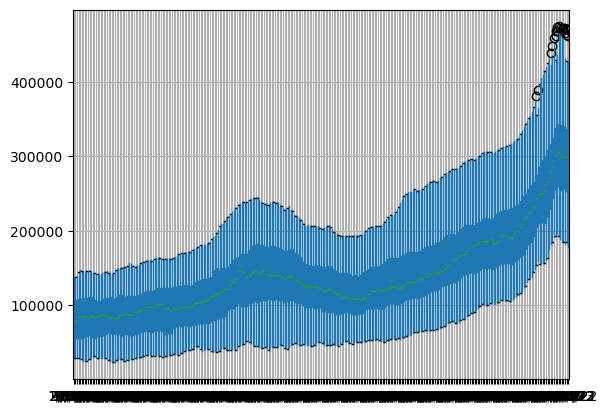

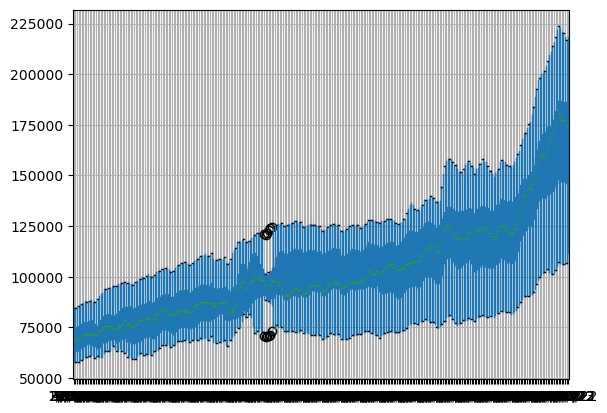

In [72]:

hot_springs.boxplot()
plt.show()
little_rock.boxplot()
plt.show()
fayetteville.boxplot()
plt.show()
searcy.boxplot()
plt.show()


In [73]:
#trying to transpose since all of the examples from the textbook and the asynch material have the dates as rows instead of colums
Arkansastranspose = Arkansas.melt(id_vars=["RegionID", "SizeRank","RegionName","State","City","Metro","CountyName"], 
        var_name="Date", 
        value_name="Value")

In [74]:
Arkansastranspose

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,Date,Value
0,89749,685,72764,AR,Springdale,"Fayetteville-Springdale-Rogers, AR",Washington County,1/31/97,93958.28784
1,89707,1116,72701,AR,Fayetteville,"Fayetteville-Springdale-Rogers, AR",Washington County,1/31/97,91367.72957
2,89743,1522,72756,AR,Rogers,"Fayetteville-Springdale-Rogers, AR",Benton County,1/31/97,78743.10013
3,89712,1526,72712,AR,Bentonville,"Fayetteville-Springdale-Rogers, AR",Benton County,1/31/97,129849.18170
4,89355,1742,72076,AR,Jacksonville,"Little Rock-North Little Rock-Conway, AR",Pulaski County,1/31/97,64640.12314
...,...,...,...,...,...,...,...,...,...
27852,89755,22368,72773,AR,Wesley,"Fayetteville-Springdale-Rogers, AR",Madison County,1/31/23,228526.41960
27853,89389,23165,72122,AR,Paron,"Little Rock-North Little Rock-Conway, AR",Saline County,1/31/23,287763.06800
27854,89332,23613,72047,AR,Enola,"Little Rock-North Little Rock-Conway, AR",Faulkner County,1/31/23,196233.24660
27855,89735,25548,72742,AR,Kingston,"Fayetteville-Springdale-Rogers, AR",Madison County,1/31/23,178094.92280


In [75]:
print(Arkansastranspose.dtypes)

RegionID        int64
SizeRank        int64
RegionName     object
State          object
City           object
Metro          object
CountyName     object
Date           object
Value         float64
dtype: object


In [96]:
Arkansastranspose[['RegionName', 'State', 'City', 'CountyName','Metro']] = Arkansastranspose[['RegionName', 'State', 'City', 'CountyName','Metro']].astype(str)
Arkansastranspose[['Value']] = Arkansastranspose[['Value']].astype(int)
Arkansastranspose['Date'] = pd.to_datetime(Arkansastranspose['Date'], format='%m/%d/%y')
Arkansastranspose['YM'] = pd.to_datetime(Arkansastranspose.Date).dt.to_period('m')



In [87]:
Arkansastranspose.head()

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,Date,Value,YM
0,89749,685,72764,AR,Springdale,"Fayetteville-Springdale-Rogers, AR",Washington County,1997-01-31,93958,1997-01
1,89707,1116,72701,AR,Fayetteville,"Fayetteville-Springdale-Rogers, AR",Washington County,1997-01-31,91367,1997-01
2,89743,1522,72756,AR,Rogers,"Fayetteville-Springdale-Rogers, AR",Benton County,1997-01-31,78743,1997-01
3,89712,1526,72712,AR,Bentonville,"Fayetteville-Springdale-Rogers, AR",Benton County,1997-01-31,129849,1997-01
4,89355,1742,72076,AR,Jacksonville,"Little Rock-North Little Rock-Conway, AR",Pulaski County,1997-01-31,64640,1997-01


In [83]:
Arkansastranspose.Metro.value_counts()


Little Rock-North Little Rock-Conway, AR    13146
Fayetteville-Springdale-Rogers, AR          10329
Searcy, AR                                   2504
Hot Springs, AR                              1878
Name: Metro, dtype: int64

(array([3138., 9902., 7291., 3886., 1868.,  904.,  473.,  243.,   86.,
          66.]),
 array([ 22723. ,  67922.8, 113122.6, 158322.4, 203522.2, 248722. ,
        293921.8, 339121.6, 384321.4, 429521.2, 474721. ]),
 <BarContainer object of 10 artists>)

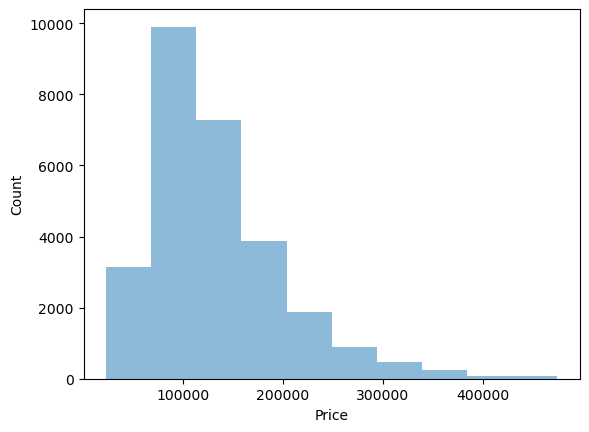

In [85]:
plt.xlabel('Price')
plt.ylabel('Count')
plt.hist(6['Value'], alpha=0.5)

In [111]:
#groups = Arkansastranspose.groupby(Grouper('Metro'))
#Metro = pd.DataFrame()

#for name, group in groups:
 #   Metro[name] = group.values
#Metro.boxplot()
#plt.show()
#print(Metro)

In [112]:



#plot_acf(Arkansastranspose, ax=plt.gca())
#plt.show()

#pyplot.subplot(212)

#plot_pacf(Arkansastranspose, ax=plt.gca())
#plt.show()

<AxesSubplot:xlabel='Metro', ylabel='Value'>

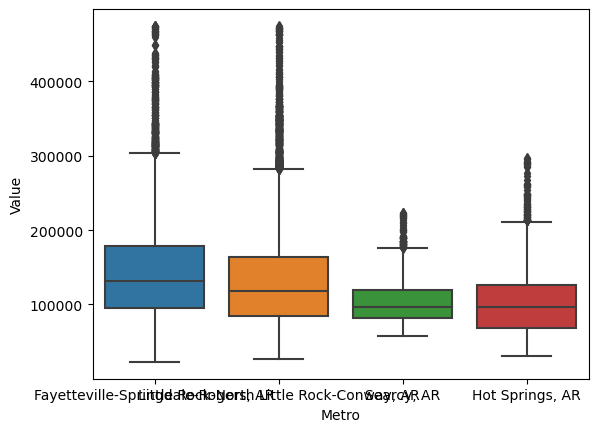

In [109]:
sns.boxplot(x='Metro', y='Value', data=Arkansastranspose)


In [203]:
zillow_df = zillow_data.drop(['RegionType','StateName'], axis=1)


In [204]:

zillow_df_transpose = zillow_df.melt(id_vars=["RegionID", "SizeRank","RegionName","State","City","Metro","CountyName"], 
        var_name="Date", 
        value_name="Value")

In [205]:
zillow_df_transpose[['RegionName', 'State', 'City', 'CountyName','Metro']] = zillow_df_transpose[['RegionName', 'State', 'City', 'CountyName','Metro']].astype(str)
zillow_df_transpose[['Value']] = zillow_df_transpose[['Value']].astype(int)
zillow_df_transpose['Date'] = pd.to_datetime(zillow_df_transpose['Date'], format='%m/%d/%y')
zillow_df_transpose['YM'] = pd.to_datetime(zillow_df_transpose.Date).dt.to_period('m')
zillow_df_transpose['Y'] = pd.to_datetime(zillow_df_transpose.Date).dt.to_period('y')
zillow_df_transpose

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,Date,Value,YM,Y
0,91940,0,77449,TX,nan,"Houston-The Woodlands-Sugar Land, TX",Harris County,1997-01-31,109765,1997-01,1997
1,91982,1,77494,TX,nan,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1997-01-31,187591,1997-01,1997
2,93144,2,79936,TX,El Paso,"El Paso, TX",El Paso County,1997-01-31,89089,1997-01,1997
3,62093,4,11385,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,1997-01-31,178634,1997-01,1997
4,95992,5,90011,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,1997-01-31,112577,1997-01,1997
...,...,...,...,...,...,...,...,...,...,...,...
3814526,77328,30657,44809,OH,nan,"Tiffin, OH",Seneca County,2023-01-31,146023,2023-01,2023
3814527,62607,30657,12489,NY,Wawarsing,"Kingston, NY",Ulster County,2023-01-31,223210,2023-01,2023
3814528,72857,30657,33847,FL,Homeland,"Lakeland-Winter Haven, FL",Polk County,2023-01-31,207809,2023-01,2023
3814529,65172,30657,17762,PA,Hughesville,"Williamsport, PA",Lycoming County,2023-01-31,157270,2023-01,2023


In [206]:
zillow_df_transpose_clean = zillow_df_transpose.drop(['RegionID','SizeRank','State','City','Metro','CountyName','YM','Y'], axis=1)

In [ ]:
#zipcodes = zillow_df_transpose_clean.transpose()

In [ ]:
#cols=list(zipcodes.columns)
#zipcodes.plot(y=cols, figsize=(15,5), grid=True)

In [ ]:
#zipcodes_delta1 = zipcodes.diff()


In [231]:
zillow_df_transpose_clean

,RegionName,Date,Value
0,77449,1997-01-31,109765
1,77494,1997-01-31,187591
2,79936,1997-01-31,89089
3,11385,1997-01-31,178634
4,90011,1997-01-31,112577
...,...,...,...
3814526,44809,2023-01-31,146023
3814527,12489,2023-01-31,223210
3814528,33847,2023-01-31,207809
3814529,17762,2023-01-31,157270


In [228]:
zillow_df_transpose_clean
zillow1 = zillow_df_transpose_clean.drop(['RegionName'],axis =1)
zillow1
zillow1[['Date', 'Value']] = zillow1[['Date', 'Value']].astype(int)


In [229]:
from pandas import Series

from statsmodels.tsa.stattools import adfuller

 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 #zillow_df_transpose
X = zillow1.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = zillow1.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

ValueError: setting an array element with a sequence.

In [234]:
zillow_df_transpose_clean

,RegionName,Date,Value
0,77449,1997-01-31,109765
1,77494,1997-01-31,187591
2,79936,1997-01-31,89089
3,11385,1997-01-31,178634
4,90011,1997-01-31,112577
...,...,...,...
3814526,44809,2023-01-31,146023
3814527,12489,2023-01-31,223210
3814528,33847,2023-01-31,207809
3814529,17762,2023-01-31,157270


In [232]:
# Split data into training and test sets
train_data = zillow_df_transpose_clean.loc['1997-01-31':'2017-12-31']
test_data = zillow_df_transpose_clean.loc['1998-01-31':'2018-12-31']

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,Date,Value,YM,Y
1997000,79305,20042,48649,MI,Oakley,"Saginaw, MI",Saginaw County,2010-08-31,72147,2010-08,2010
1997001,82235,20042,55384,MN,Spring Park,"Minneapolis-St. Paul-Bloomington, MN-WI",Hennepin County,2010-08-31,397660,2010-08,2010
1997002,77894,20045,45889,OH,Van Buren,"Findlay, OH",Hancock County,2010-08-31,180132,2010-08,2010
1997003,67653,20048,23315,VA,Carrsville,"Virginia Beach-Norfolk-Newport News, VA-NC",Isle of Wight County,2010-08-31,188602,2010-08,2010
1997004,80166,20054,50135,IA,Kellogg,"Des Moines-West Des Moines, IA",Jasper County,2010-08-31,90196,2010-08,2010
...,...,...,...,...,...,...,...,...,...,...,...
2016995,72192,8683,32754,FL,Mims,"Palm Bay-Melbourne-Titusville, FL",Brevard County,2010-10-31,147429,2010-10,2010
2016996,78953,8686,48079,MI,Saint Clair,"Detroit-Warren-Dearborn, MI",Saint Clair County,2010-10-31,144340,2010-10,2010
2016997,97539,8689,94065,CA,Redwood City,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2010-10-31,879632,2010-10,2010
2016998,93636,8693,81008,CO,Pueblo,"Pueblo, CO",Pueblo County,2010-10-31,154346,2010-10,2010


In [ ]:
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

In [233]:


#this ran for over an hour and didn't output anything 


# Create Prophet models for each zip code
zip_codes = zillow_df_transpose['RegionName'].unique()
models = {}
for zip_code in zip_codes:
    # Create new DataFrame with relevant columns for this zip code
    zip_data = train_data[train_data['RegionName'] == zip_code][['Date', 'Value']]
    zip_data.columns = ['ds', 'y']
    # Fit a Prophet model to this DataFrame
    model = Prophet()
    model.fit(zip_data)
    models[zip_code] = model

# Make predictions for each zip code for 2018
preds = {}
for zip_code in zip_codes:
    # Create new DataFrame with dates for 2018
    dates = pd.date_range(start='2018-01-01', end='2018-12-31', freq='D')
    preds_df = pd.DataFrame({'ds': dates})
    # Use fitted model to make predictions for this zip code
    preds_df['yhat'] = models[zip_code].predict(preds_df)['yhat']
    preds[zip_code] = preds_df

# Visualize predicted housing prices for each zip code
for zip_code in zip_codes:
    preds[zip_code].plot(x='ds', y='yhat', title=f'Predicted housing prices for zip code {zip_code}')


KeyboardInterrupt: 